In [3]:
!pip install opencv-python numpy

Defaulting to user installation because normal site-packages is not writeable


Lucas kanade for video

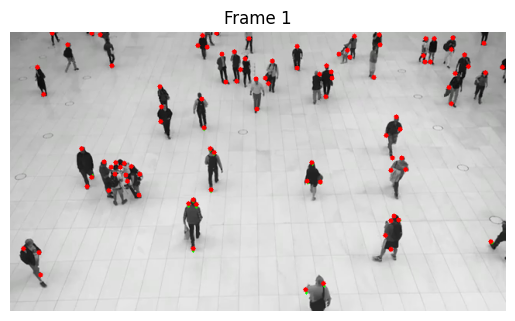

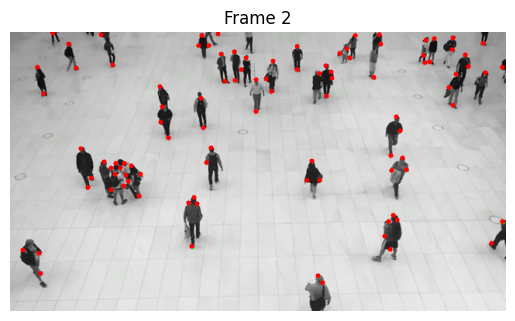

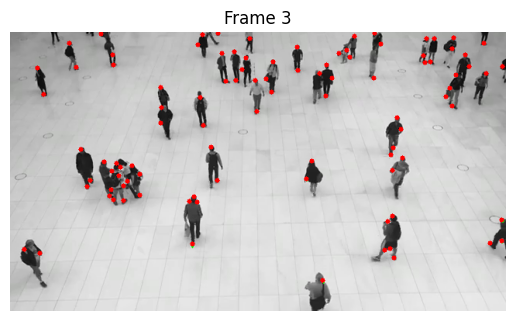

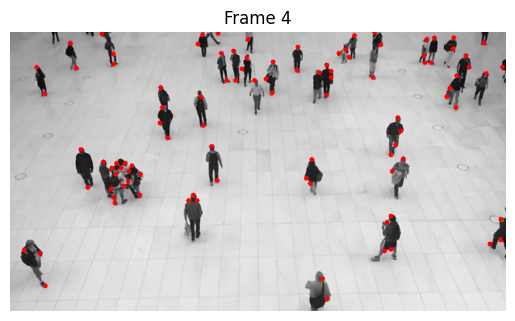

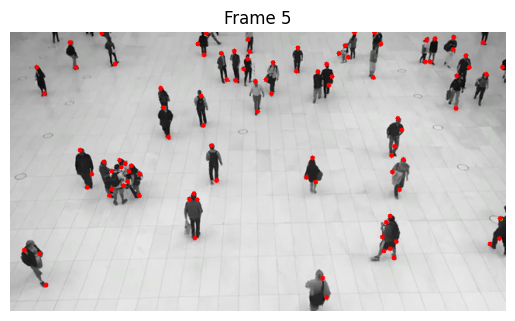

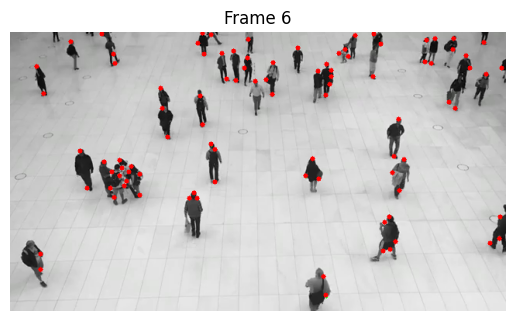

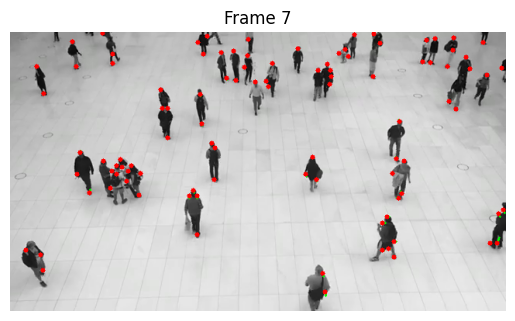

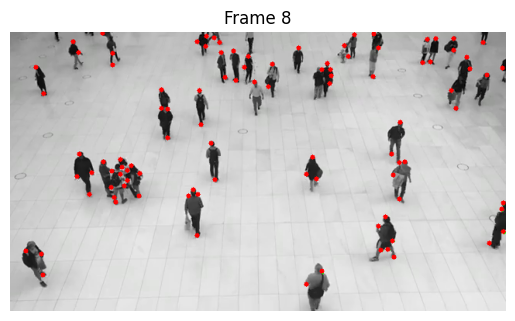

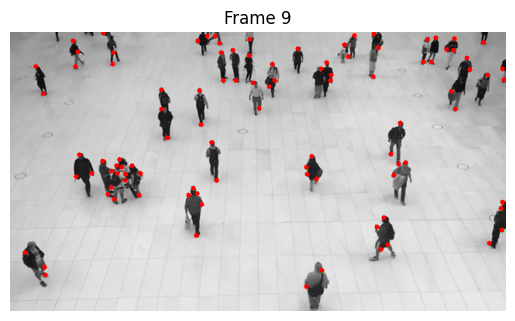

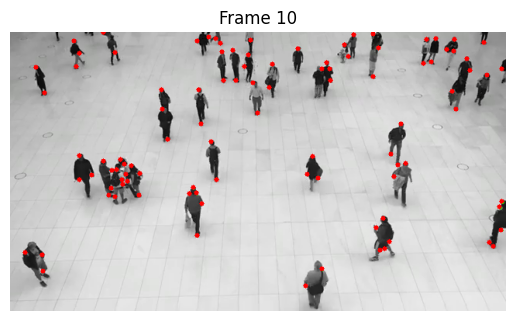

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def estimate_optical_flow_lk(previous_frame, current_frame, **kwargs):
    lk_params = dict(winSize=(kwargs.get('winSize_width', 15), kwargs.get('winSize_height', 15)),
                     maxLevel=kwargs.get('maxLevel', 2),
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                               kwargs.get('criteria_max_iter', 10), kwargs.get('criteria_epsilon', 0.03)))
    feature_params = dict(maxCorners=kwargs.get('maxCorners', 100),
                          qualityLevel=kwargs.get('qualityLevel', 0.3),
                          minDistance=kwargs.get('minDistance', 7),
                          blockSize=kwargs.get('blockSize', 7))
    points1 = cv2.goodFeaturesToTrack(previous_frame, mask=None, **feature_params)

    if points1 is not None:
        points2, status, errors = cv2.calcOpticalFlowPyrLK(previous_frame, current_frame, points1, None, **lk_params)
        return points2, status, errors, points1
    else:
        return None, None, None, None

def visualize_tracked_points(frame, points1, points2, status):
    if points1 is not None and points2 is not None and status is not None:
        for i, (new, old) in enumerate(zip(points2, points1)):
            if status[i] == 1:
                a, b = new.ravel()
                c, d = old.ravel()
                cv2.line(frame, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
                cv2.circle(frame, (int(a), int(b)), 3, (0, 0, 255), -1)
    return frame

def main():
    video_path = 'e11.mp4'
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return

    ret, prev_frame_color = cap.read()
    if not ret:
        print("Error reading the first frame.")
        cap.release()
        return
    prev_frame_gray = cv2.cvtColor(prev_frame_color, cv2.COLOR_BGR2GRAY)

    lk_params = {
        'winSize_width': 15,
        'winSize_height': 15,
        'maxLevel': 2,
        'criteria_max_iter': 10,
        'criteria_epsilon': 0.03,
        'maxCorners': 100,
        'qualityLevel': 0.3,
        'minDistance': 7,
        'blockSize': 7
    }

    frame_count = 0
    while frame_count < 10:
        ret, current_frame_color = cap.read()
        if not ret:
            print("End of video.")
            break

        current_frame_gray = cv2.cvtColor(current_frame_color, cv2.COLOR_BGR2GRAY)

        points2, status, errors, points1 = estimate_optical_flow_lk(prev_frame_gray, current_frame_gray, **lk_params)

        if points2 is not None and status is not None and points1 is not None:
            good_new = points2[status == 1]
            good_old = points1[status == 1]
            output_frame = visualize_tracked_points(current_frame_color.copy(), good_old, good_new, status)
        else:
            output_frame = current_frame_color

        # Convert BGR to RGB for matplotlib
        output_rgb = cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB)

        # Display using matplotlib
        plt.imshow(output_rgb)
        plt.title(f"Frame {frame_count + 1}")
        plt.axis('off')
        plt.show()

        # Prepare for next iteration
        prev_frame_gray = current_frame_gray.copy()
        frame_count += 1

    cap.release()

if __name__ == "__main__":
    main()


Kanade kucas tomasi for videos

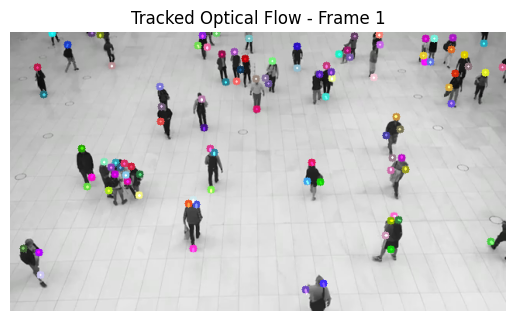

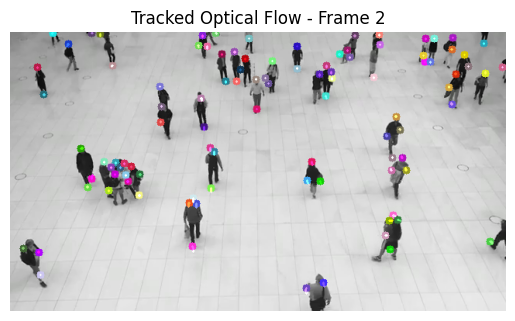

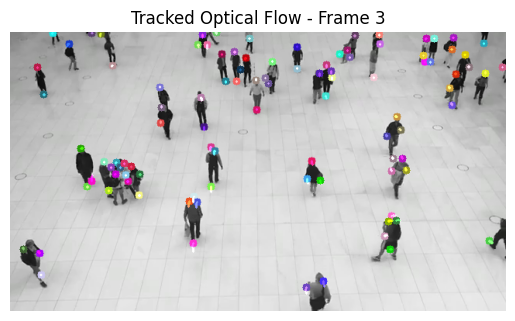

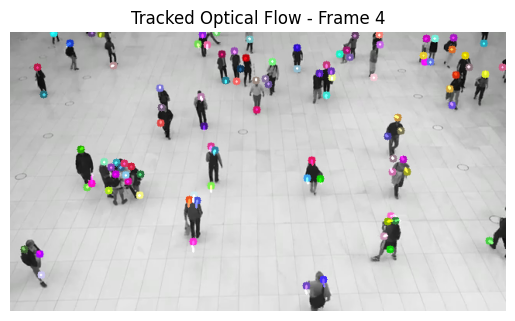

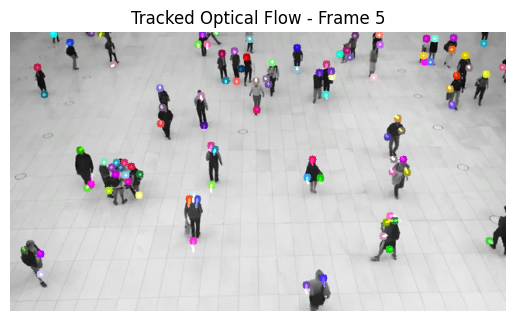

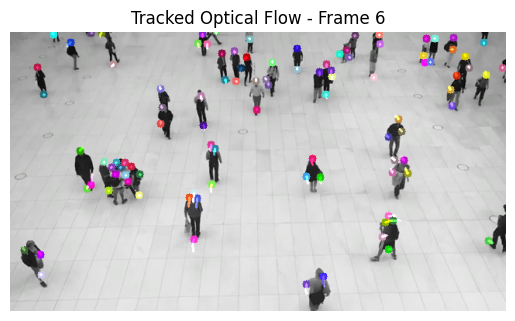

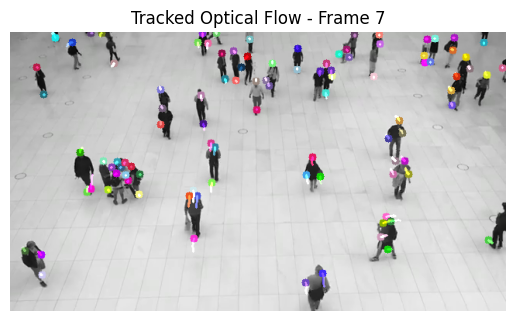

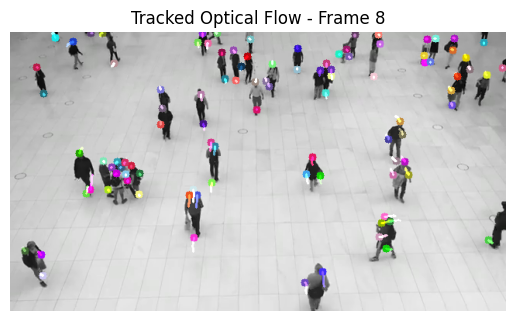

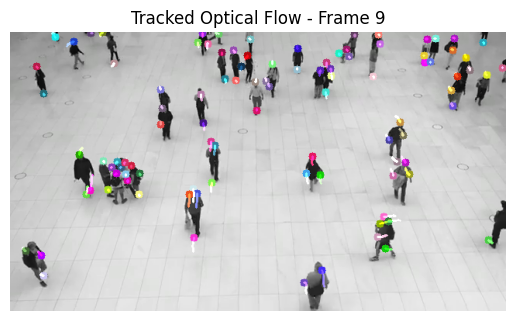

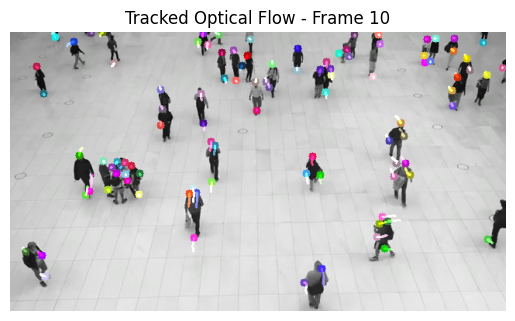

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parameters for Shi-Tomasi corner detection
feature_params = dict(maxCorners=100,
                      qualityLevel=0.3,
                      minDistance=7,
                      blockSize=7)

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create random colors for drawing tracks
color = np.random.randint(0, 255, (100, 3))

# Open the video file
video_path = 'e11.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video file: {video_path}")
    exit()

# Read the first frame and find initial corners
ret, old_frame = cap.read()
if not ret:
    print("Error reading the first frame.")
    cap.release()
    exit()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

frame_count = 0
while frame_count < 10:
    ret, frame = cap.read()
    if not ret:
        print("End of video.")
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if p0 is not None:
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        # Draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)

        img = cv2.add(frame, mask)

        # Convert to RGB for matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Show the frame using matplotlib
        plt.imshow(img_rgb)
        plt.title(f"Tracked Optical Flow - Frame {frame_count + 1}")
        plt.axis('off')
        plt.show()

        # Update for next iteration
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
    else:
        # Redetect if no points are tracked
        p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
        mask = np.zeros_like(old_frame)  # Reset mask
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(f"Redetecting - Frame {frame_count + 1}")
        plt.axis('off')
        plt.show()

    frame_count += 1

cap.release()


Lucas cannade for images

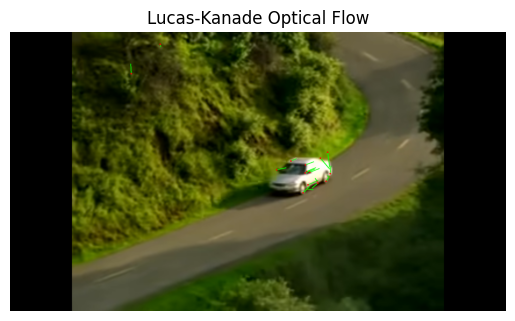

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def estimate_lucas_kanade_flow_image(prev_img_gray, curr_img_gray, points1, **lk_params):
    points2, status, errors = cv2.calcOpticalFlowPyrLK(prev_img_gray, curr_img_gray, points1, None, **lk_params)
    return points2, status, errors

def visualize_flow_on_image(curr_img_color, points1, points2, status):
    if points1 is not None and points2 is not None and status is not None:
        for i, (new, old) in enumerate(zip(points2, points1)):
            if status[i] == 1:
                a, b = new.ravel()
                c, d = old.ravel()
                curr_img_color = cv2.line(curr_img_color, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
                curr_img_color = cv2.circle(curr_img_color, (int(a), int(b)), 3, (0, 0, 255), -1)
    return curr_img_color

if __name__ == "__main__":
    prev_image_path = 'e11a.png'  # First image
    curr_image_path = 'e11b.png'  # Second image

    prev_img_color = cv2.imread(prev_image_path)
    curr_img_color = cv2.imread(curr_image_path)

    if prev_img_color is None or curr_img_color is None:
        print("Error: Could not load one or both images.")
        exit()

    prev_img_gray = cv2.cvtColor(prev_img_color, cv2.COLOR_BGR2GRAY)
    curr_img_gray = cv2.cvtColor(curr_img_color, cv2.COLOR_BGR2GRAY)

    # Resize second image to match the first
    height_prev, width_prev = prev_img_gray.shape[:2]
    curr_img_gray_resized = cv2.resize(curr_img_gray, (width_prev, height_prev))
    curr_img_color_resized = cv2.resize(curr_img_color, (width_prev, height_prev))

    lk_params = dict(winSize=(15, 15),
                     maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    feature_params = dict(maxCorners=100,
                          qualityLevel=0.3,
                          minDistance=7,
                          blockSize=7)

    points1 = cv2.goodFeaturesToTrack(prev_img_gray, mask=None, **feature_params)

    if points1 is not None:
        points2, status, errors = estimate_lucas_kanade_flow_image(prev_img_gray, curr_img_gray_resized, points1, **lk_params)

        if points2 is not None and status is not None:
            output_image = visualize_flow_on_image(curr_img_color_resized.copy(), points1, points2, status)

            # Convert BGR to RGB for matplotlib
            output_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

            # Display using matplotlib
            plt.imshow(output_rgb)
            plt.title("Lucas-Kanade Optical Flow")
            plt.axis('off')
            plt.show()
        else:
            print("No flow detected.")
    else:
        print("No initial feature points detected.")


Kanade lucas tomasi for images

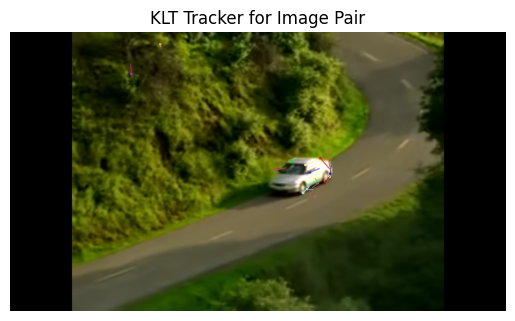

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_tracks(frame, points, old_points, colors):
    """Visualizes the tracked points and their trajectories."""
    if old_points is not None and points is not None:
        for i, (new, old) in enumerate(zip(points, old_points)):
            a, b = new.ravel()
            c, d = old.ravel()
            frame = cv2.line(frame, (int(a), int(b)), (int(c), int(d)), colors[i].tolist(), 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, colors[i].tolist(), -1)
    elif points is not None:
        for i, new in enumerate(points):
            a, b = new.ravel()
            frame = cv2.circle(frame, (int(a), int(b)), 5, colors[i].tolist(), -1)
    return frame

if __name__ == "__main__":
    # Load the two images
    prev_image_path = 'e11a.png'
    curr_image_path = 'e11b.png'

    prev_img_color = cv2.imread(prev_image_path)
    curr_img_color = cv2.imread(curr_image_path)

    if prev_img_color is None or curr_img_color is None:
        print("Error: Could not load one or both images.")
        exit()

    prev_gray = cv2.cvtColor(prev_img_color, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_img_color, cv2.COLOR_BGR2GRAY)

    # Resize second image to match first
    height_prev, width_prev = prev_gray.shape[:2]
    curr_gray_resized = cv2.resize(curr_gray, (width_prev, height_prev))
    curr_color_resized = cv2.resize(curr_img_color, (width_prev, height_prev))

    feature_params = dict(maxCorners=100,
                          qualityLevel=0.3,
                          minDistance=7,
                          blockSize=7)

    lk_params = dict(winSize=(15, 15),
                     maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    p0 = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)

    if p0 is not None:
        colors = np.random.randint(0, 255, (100, 3))

        p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray_resized, p0, None, **lk_params)

        if p1 is not None and st is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

            output_image = visualize_tracks(curr_color_resized.copy(), good_new, good_old, colors)

            # Convert BGR to RGB for matplotlib
            output_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

            # Show with matplotlib
            plt.imshow(output_rgb)
            plt.title("KLT Tracker for Image Pair")
            plt.axis('off')
            plt.show()
        else:
            print("No points tracked.")
    else:
        print("No good features found in the first image.")
